In [3]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F # Loss function
import torchvision.datasets as datasets # 讀取資料
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models # 載入預訓練的模型
import torchvision.transforms as transforms # 將資料轉換成符合預訓練模型的形式
import matplotlib.pyplot as plt # 顯示圖片

device = torch.device("cuda")

img_path = 'hw6_data/images/'
data_path = 'hw6_data/'

# 读入图片 + 预处理

In [17]:
# 實作一個繼承 torch.utils.data.Dataset 的 Class 來讀取圖片
class Adverdataset(Dataset):
    def __init__(self, img_path, label_path):
        self.img_path = img_path
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False) # 把圖片 normalize 到 0~1 之間 mean 0 variance 1
        self.transforms = transforms.Compose([transforms.Resize((224, 224), interpolation=3), transforms.ToTensor(), self.normalize])
        self.img_names = []
        for i in range(200):# 已知資料總共有 200 張圖片
            self.img_names.append("{:03d}".format(i))
        # 获得label
        self.label = pd.read_csv(label_path + "labels.csv")
        self.label = self.label.loc[:, 'TrueLabel'].to_numpy()
        self.label = torch.from_numpy(self.label).long()
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_names[index] + '.png'))#  利用路徑讀取圖片
        img = self.transforms(img) # 將輸入的圖片轉換成符合預訓練模型的形式
        label = self.label[index] # 圖片相對應的 label
        return img, label
    
    def __len__(self):
        return 200 # 由於已知這次的資料總共有 200 張圖片 所以回傳 200

# 載入模型 + 定义 FGSM 攻擊类

In [26]:
class Attacker:
    def __init__(self, img_path, data_path):
        self.model = models.vgg16(pretrained = True) # 讀入預訓練模型 vgg16
        self.model.cuda()
        self.model.eval()
        self.dataset = Adverdataset(img_path, data_path) # 利用 Adverdataset 這個 class 讀取資料
        self.loader = torch.utils.data.DataLoader(self.dataset, batch_size = 1, shuffle = False)
     
    # FGSM 攻擊
    def fgsm_attack(self, image, epsilon, data_grad): # epsilon 是
        sign_data_grad = data_grad.sign() # 找出 gradient 的方向
        perturbed_image = image + epsilon * sign_data_grad # 將圖片加上 gradient 方向乘上 epsilon 的 noise
        return perturbed_image
    
    def attack(self, epsilon):
        adv_examples = [] # 存下一些成功攻擊後的圖片 以便之後顯示
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader: # data = img, target = label，对每张照片都攻击一次
            data, target = data.to(device), target.to(device)
            data_raw = data;
            data.requires_grad = True
            output = self.model(data) # 將原始圖片丟入 model 進行測試 得出相對應的分类
            init_pred = output.max(1, keepdim = True)[1]

            if init_pred.item() != target.item(): # 如果原始圖片 model 分类錯誤 就不進行攻擊
                wrong += 1
                continue
            
            # 如果分类正確 就開始計算 gradient 進行 FGSM 攻擊
            loss = F.nll_loss(output, target)
            self.model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad) # 攻击 1 次
            output = self.model(perturbed_data) # 再將加入 noise 的圖片丟入 model 進行測試
            final_pred = output.max(1, keepdim=True)[1] # 得出相對應的分类  
          
            if final_pred.item() == target.item(): # 攻击不一定成功，辨識結果不变，则攻擊失敗
                fail += 1
            else:
                success += 1 # 辨識变化，则攻擊成功
                if len(adv_examples) < 5: # 將攻擊成功的圖片存入
                    adv_ex = perturbed_data * torch.tensor(self.dataset.std, device = device).view(3, 1, 1) + torch.tensor(self.dataset.mean, device = device).view(3, 1, 1)
                    adv_ex = adv_ex.squeeze().detach().cpu().numpy() 
                    data_raw = data_raw * torch.tensor(self.dataset.std, device = device).view(3, 1, 1) + torch.tensor(self.dataset.mean, device = device).view(3, 1, 1)
                    data_raw = data_raw.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , adv_ex) )        
        final_acc = (fail / (wrong + success + fail))
        
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc


# 執行攻擊 + 顯示攻擊成功率

In [25]:
if __name__ == '__main__':
    label_name = pd.read_csv(data_path + "categories.csv")
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    attacker = Attacker(img_path, data_path) # new 一個 Attacker class
    
    epsilons = [0.1, 0.01] # 要嘗試的 epsilon

    accuracies, examples = [], []

    # 進行攻擊 並存起正確率和攻擊成功的圖片
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)

Epsilon: 0.1	Test Accuracy = 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



# 顯示 FGSM 產生的圖片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


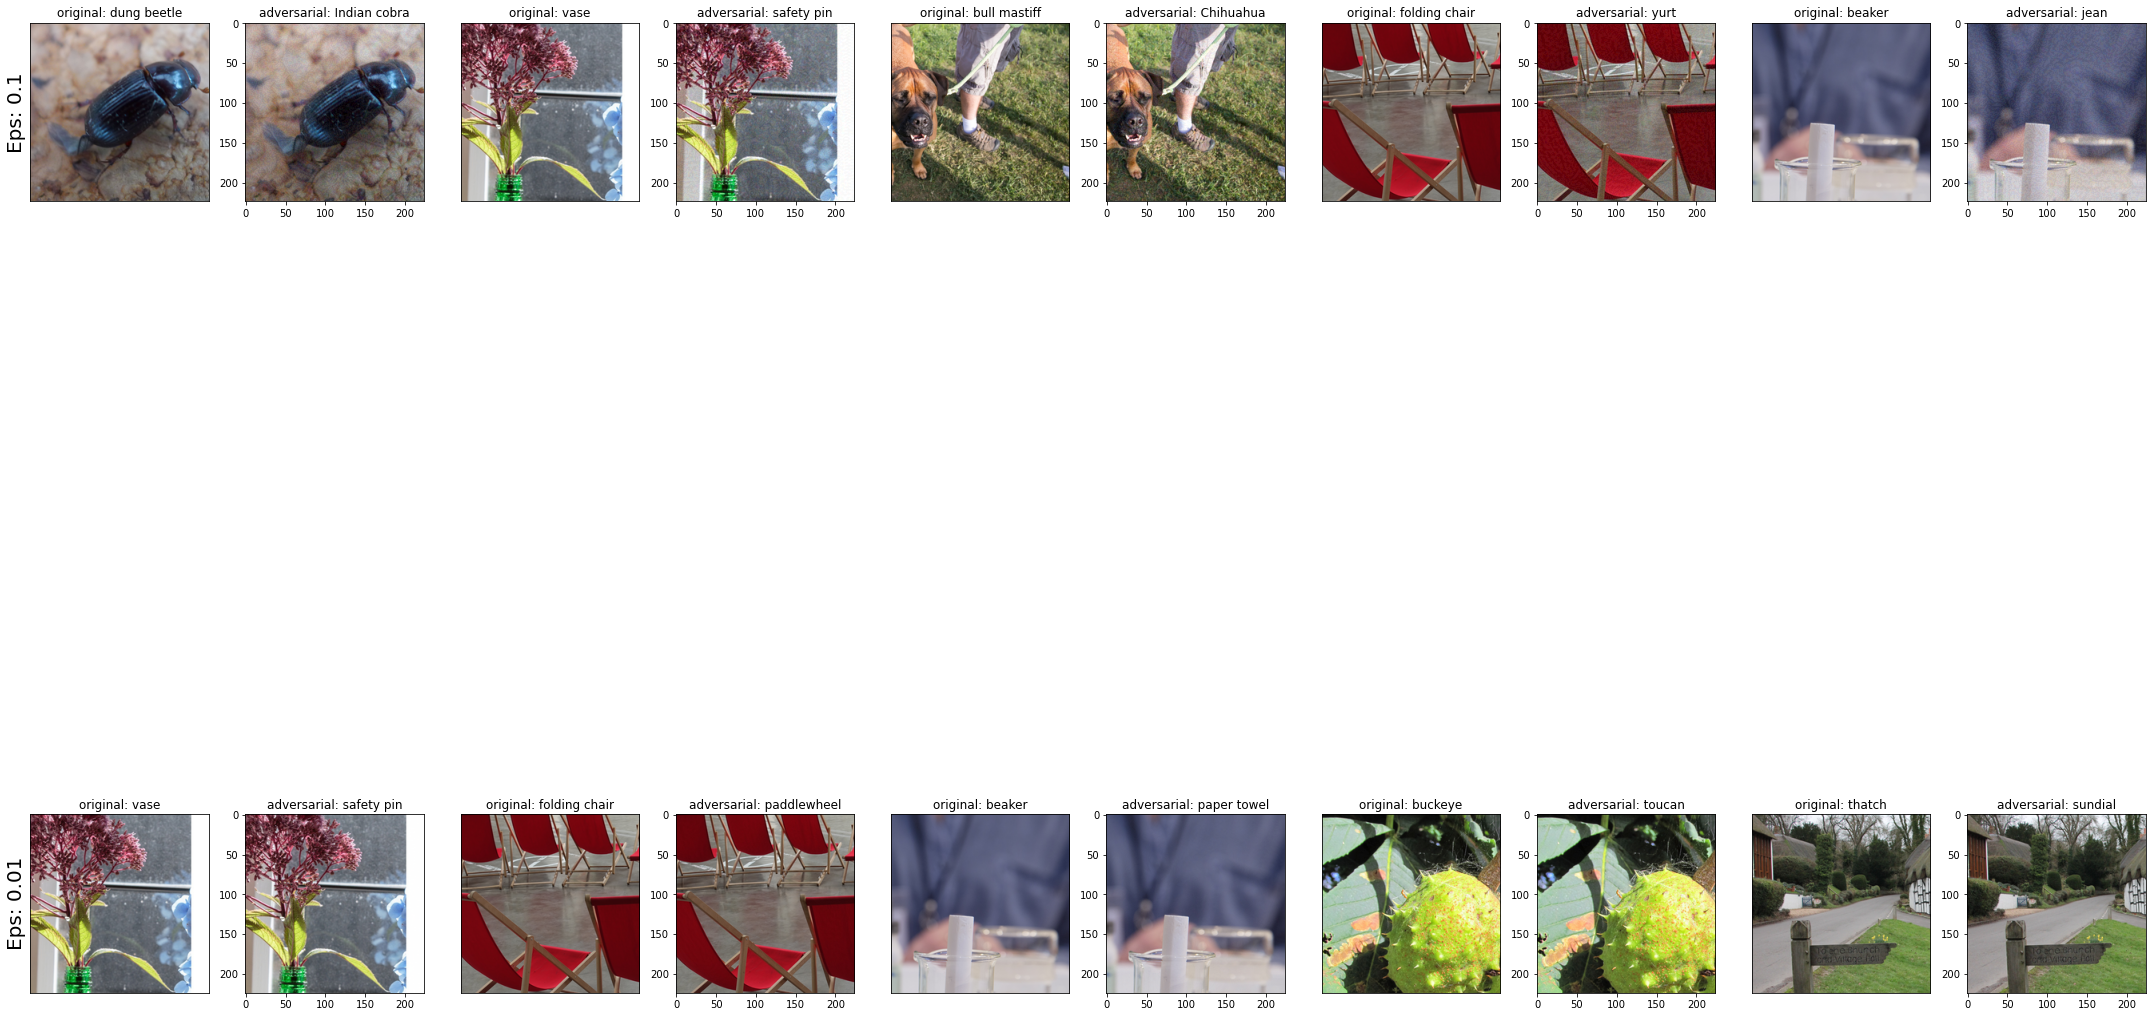

In [27]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=20)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()